# Kalman Filter

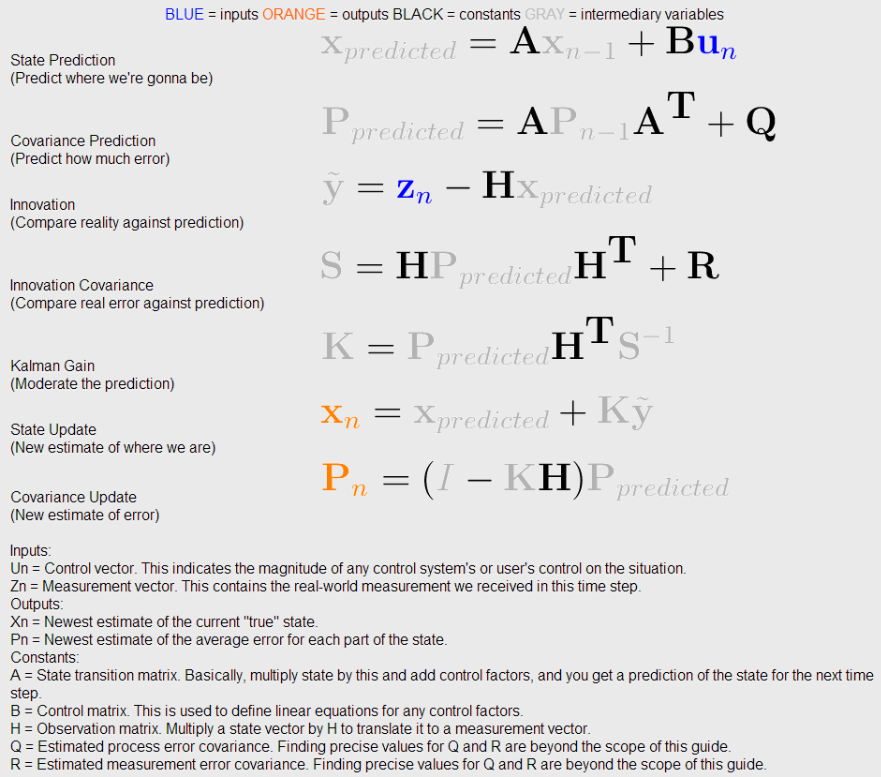

In [ ]:
import numpy as np
import pandas as pd

# Define the Kalman filter function
def kalman_filter(x, P, dt, Q, R, ax, ay, az, gx, gy, gz):
    n = len(ax)
    states = np.zeros((n, 12))
    for t in range(n):
        # Predict the next state
        #in a 6-degree-of-freedom navigation problem, the state vector include
        #position (3 elements), velocity (3 elements), orientation (3 elements), and angular velocity (3 elements), 
        #for a total of 12 elements.
        F = np.array([[1, 0, 0, dt, 0, 0, 0.5*dt**2, 0, 0, 0, 0, 0],  #state transition function
                      [0, 1, 0, 0, dt, 0, 0, 0.5*dt**2, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0, dt, 0, 0, 0.5*dt**2, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0, dt, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 1, 0, 0, dt, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 1, 0, 0, dt, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 1, 0, 0, gx[t], gy[t], gz[t]],
                      [0, 0, 0, 0, 0, 0, 0, 1, 0, -gy[t], gx[t], 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, gz[t]],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
        x = np.matmul(F, x) #state prediction
        P = np.matmul(F, np.matmul(P, F.T)) + Q #covariance prediction
        
        ################################################
        #           Muhammad Talha Ejaz                #
        #          talha.ej@hotmail.com                #   
        ################################################
                # Update the state estimate
        H = np.zeros((6, 12)) #measurment function
        
        H[:3, 3:6] = dt*np.eye(3)
        z = np.array([ax[t], ay[t], az[t], gx[t], gy[t], gz[t]])
        y = z - np.matmul(H, x)  #innovation
        S = np.matmul(H, np.matmul(P, H.T)) + R  #State Update
        K = np.matmul(P, np.matmul(H.T, np.linalg.inv(S))) #kalman Gain Moderate predction
        x = x + np.matmul(K, y)
        P = np.matmul((np.eye(12) - np.matmul(K, H)), P) #Covariance Update
        states[t, :] = x

    return states


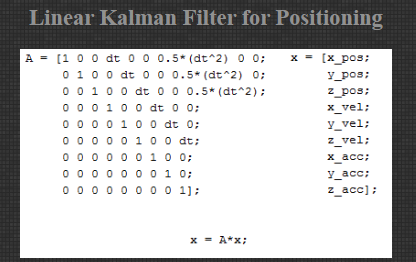

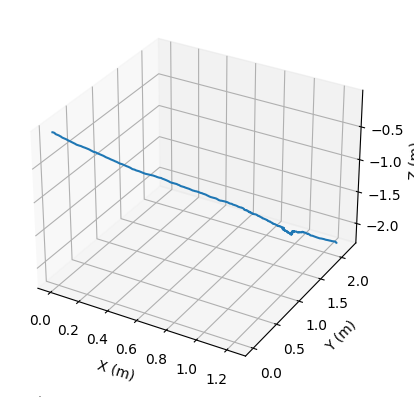

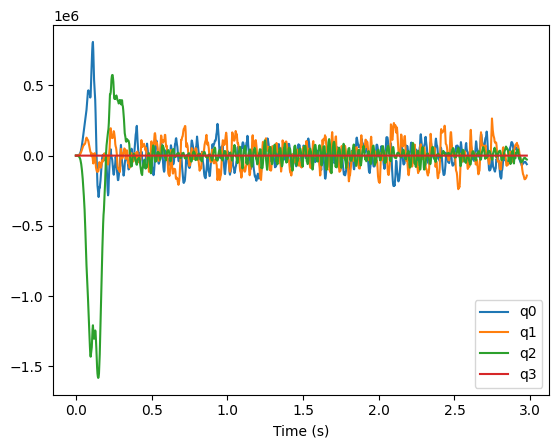

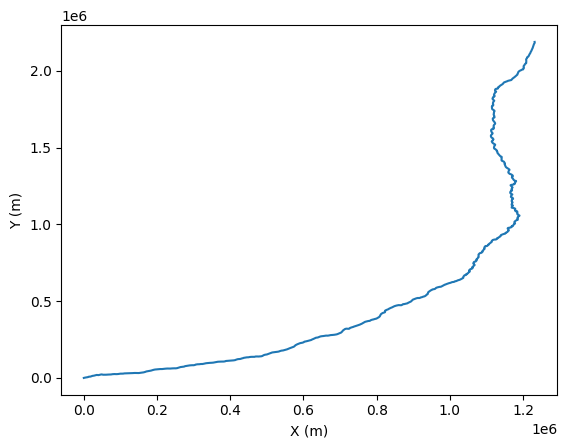

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the Kalman filter function (as before)

# Load the accelerometer and gyroscope readings from the CSV file
data = pd.read_csv('data.csv')
ax = data['AcX'].values
ay = data['AcY'].values
az = data['AcZ'].values
gx = np.radians(data['GyX'].values)
gy = np.radians(data['GyY'].values)
gz = np.radians(data['GyZ'].values)

# Run the Kalman filter
x = kalman_filter(np.zeros(12), np.diag([100, 100, 100, 10, 10, 10, 1, 0, 0, 0.1, 0.1, 0.1]), 0.025, np.diag([0.03]*12), np.diag([100, 100, 100, .1, .1, .1]), ax, ay, az, gx, gy, gz)
# x = kalman_filter(np.zeros(12), np.diag([100, 100, 100, 10, 10, 10, 1, 0, 0, 0.1, 0.1, 0.1]), 0.005, np.diag([0.3]*12), np.eye(6), ax, ay, az, gx, gy, gz)

# Plot the estimated position
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x[:,0], x[:,1], x[:,2])
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
plt.show()

# Plot the estimated orientation
fig = plt.figure()
subplot = fig.add_subplot(111)
t = np.arange(len(x)) * 0.0025
subplot.plot(t, x[:,6], label='q0')
subplot.plot(t, x[:,7], label='q1')
subplot.plot(t, x[:,8], label='q2')
subplot.plot(t, x[:,9], label='q3')
subplot.legend()
subplot.set_xlabel('Time (s)')
plt.show()
#plot 2D
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x[:,0], x[:,1])
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
plt.show()

Yes, quaternion components of the orientation are typically represented by four values. A quaternion is a mathematical object that can be used to represent 3D rotations and orientations. It consists of a scalar part and a vector part, and it has the form:

q = w + xi + yj + zk

Here, w, x, y, and z are the quaternion components, and i, j, and k are the imaginary units.

Quaternions have some advantages over other representations of 3D rotations, such as rotation matrices or Euler angles. They are more compact, less susceptible to gimbal lock, and can be easily interpolated.

In the context of the provided code, it's not clear whether the state vector actually contains quaternion components or some other representation of the orientation. You might need to consult the original source or documentation of the code to confirm this.

To apply an Extended Kalman Filter (EKF) to the same data, you need to modify the kalman_filter function to use the nonlinear process and measurement models. The EKF is an extension of the basic Kalman Filter that can handle nonlinear models by linearizing them using the Jacobian matrix.

# EKF

In [ ]:
def f(x, gx, gy, gz, dt):
    F = np.array([[1, 0, 0, dt, 0, 0, 0.5*dt**2, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, dt, 0, 0, 0.5*dt**2, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, dt, 0, 0, 0.5*dt**2, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, dt, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, dt, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0, dt, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 0, 0, gx, gy, gz],
                  [0, 0, 0, 0, 0, 0, 0, 1, 0, -gy, gx, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, gz],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
    return np.matmul(F, x)

def h(x):
    return x[:6]

def F_jac(x, gx, gy, gz, dt):
    F = np.array([[1, 0, 0, dt, 0, 0, 0.5*dt**2, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, dt, 0, 0, 0.5*dt**2, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, dt, 0, 0, 0.5*dt**2, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, dt, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, dt, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0, dt, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 0, 0, gx, gy, gz],
                  [0, 0, 0, 0, 0, 0, 0, 1, 0, -gy, gx, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, gz],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
    return F


def H_jac(x):
    H = np.zeros((6, 12))
    H[:6, :6] = np.eye(6)
    return H

def extended_kalman_filter(x, P, dt, Q, R, ax, ay, az, gx, gy, gz):
    n = len(ax)
    states = np.zeros((n, 12))

    for t in range(n):
        # Predict the next state
        x = f(x, gx[t], gy[t], gz[t], dt)
        F = F_jac(x, gx[t], gy[t], gz[t], dt)
        P = np.matmul(F, np.matmul(P, F.T)) + Q

        # Update the state estimate
        H = H_jac(x)
        z = np.array([ax[t], ay[t], az[t], gx[t], gy[t], gz[t]])
        y = z - h(x)
        S = np.matmul(H, np.matmul(P, H.T)) + R
        K = np.matmul(P, np.matmul(H.T, np.linalg.inv(S)))
        x = x + np.matmul(K, y)
        P = np.matmul((np.eye(12) - np.matmul(K, H)), P)

        states[t, :] = x

    return states

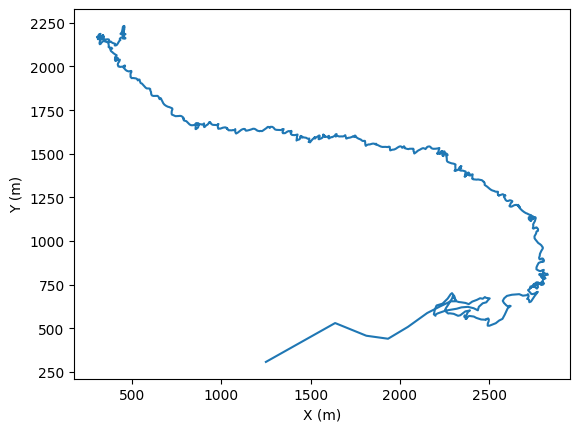

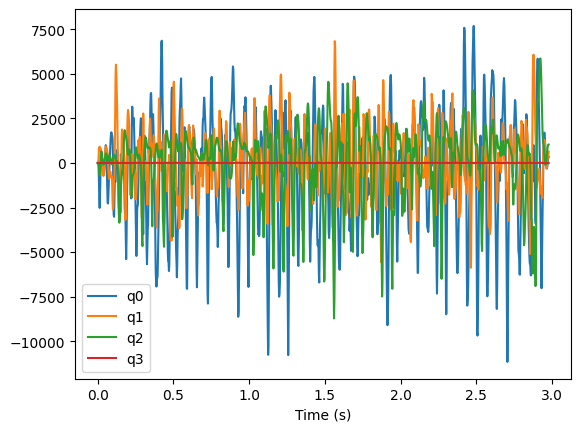

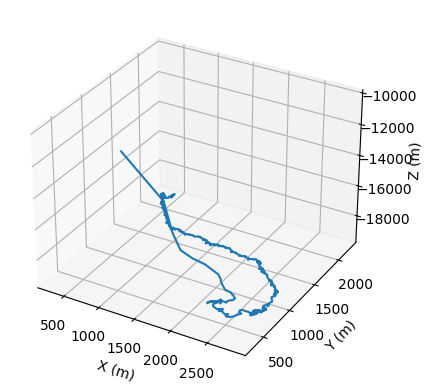

In [ ]:
# Load the accelerometer and gyroscope readings from the CSV file
# data = pd.read_csv('data.csv')
ax = data['AcX'].values
# ay = data['AcY'].values
# az = data['AcZ'].values
# gx = np.radians(data['GyX'].values)
# gy = np.radians(data['GyY'].values)
# gz = np.radians(data['GyZ'].values)
# Run the Kalman filter
x = extended_kalman_filter(np.zeros(12), np.diag([100, 100, 100, 10, 10, 10, 1, 0, 0, 0.1, 0.1, 0.1]), 0.0025, np.diag([0.001]*12), np.diag([100,100, 100, 0.1, 0.1, 0.1]), ax, ay, az, gx, gy, gz)

# Plot the estimated position
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x[:,0], x[:,1])
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
plt.show()

################################################
#           Muhammad Talha Ejaz                #
#          talha.ej@hotmail.com                #   
################################################

fig = plt.figure()
subplot = fig.add_subplot(111)
t = np.arange(len(x)) * 0.0025
subplot.plot(t, x[:,6], label='q0')
subplot.plot(t, x[:,7], label='q1')
subplot.plot(t, x[:,8], label='q2')
subplot.plot(t, x[:,9], label='q3')
subplot.legend()
subplot.set_xlabel('Time (s)')
plt.show()

#3D
# Plot the estimated position
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x[:,0], x[:,1], x[:,2])
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
plt.show()

# UKF

In [ ]:
!pip install filterpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints


def f_ukf(x, dt, gx, gy, gz):
    F = np.array([[1, 0, 0, dt, 0, 0, 0.5*dt**2, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, dt, 0, 0, 0.5*dt**2, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, dt, 0, 0, 0.5*dt**2, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, dt, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, dt, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0, dt, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 0, 0, gx, gy, gz],
                  [0, 0, 0, 0, 0, 0, 0, 1, 0, -gy, gx, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, gz],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
    return np.dot(F, x)

def h_ukf(x):
    return x[3:9]

def unscented_kalman_filter(ax, ay, az, gx, gy, gz, dt, Q, R):
    n = len(ax)
    dim_x = 12
    dim_z = 6
#     f_ukf = f_ukf(x, dt, gx, gy, gz)
#     h_ukf = h_ukf(x)
    sigma_points = MerweScaledSigmaPoints(dim_x, alpha=1e-3, beta=2, kappa=0)
    
    ################################################
    #           Muhammad Talha Ejaz                #
    #          talha.ej@hotmail.com                #   
    ################################################
    ukf = UnscentedKalmanFilter(dim_x=dim_x, dim_z=dim_z, dt=dt, fx=f_ukf, hx=h_ukf, points=sigma_points)
    ukf.x = np.zeros(dim_x)  # Initial state
    #ukf.P = np.diag([100, 100, 100, 10, 10, 10, 1, 0, 0, 0.1, 0.1, 0.1])  # Initial covariance
    ukf.P = np.diag([1000, 1000, 1000, 10, 10, 10, 1, 1, 1, 0.1, 0.1, 0.1])
    ukf.R = R  # Measurement noise
    ukf.Q = Q  # Process noise

    states = np.zeros((n, dim_x))

    for t in range(n):
        ukf.predict(dt=dt, gx=gx[t], gy=gy[t], gz=gz[t])
        ukf.update(np.array([ax[t], ay[t], az[t], gx[t], gy[t], gz[t]]))
        states[t, :] = ukf.x.copy()

    return states


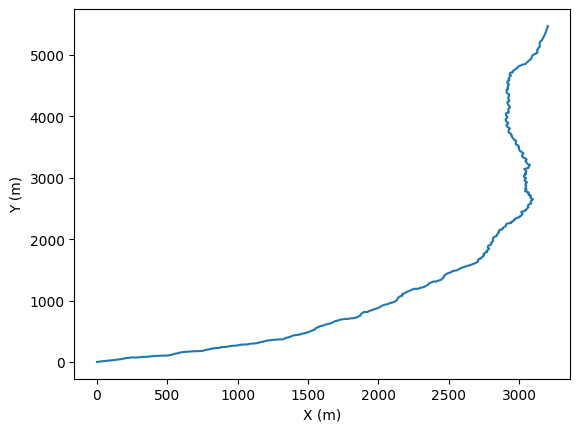

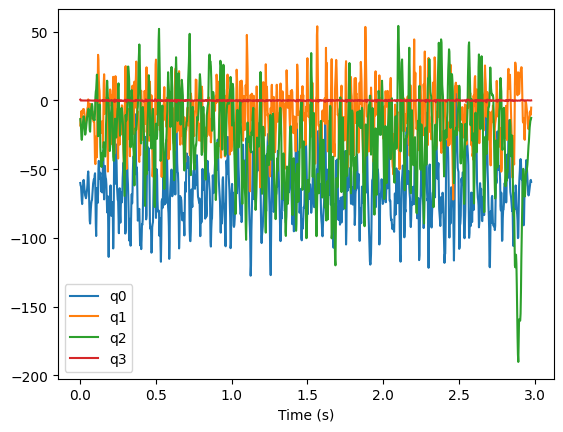

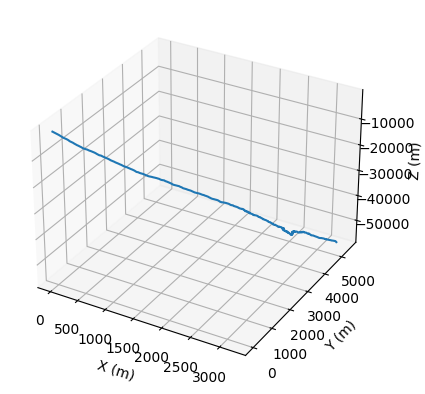

In [ ]:
# Load the accelerometer and gyroscope readings from the CSV file
# Load the sensor data
data = pd.read_csv('data.csv')
ax = data['AcX'].values
ay = data['AcY'].values
az = data['AcZ'].values
gx = np.radians(data['GyX'].values)
gy = np.radians(data['GyY'].values)
gz = np.radians(data['GyZ'].values)

# Define the time interval, process noise, and measurement noise
dt = 0.0025  # Adjust this value according to your data
# Q = np.diag([0.01]*12)  # Tuning parameter
# R = np.diag([100, 100, 100, 0.1, 0.1, 0.1])  # Tuning parameter

Q = np.diag([0.001]*12) + np.eye(12) * 1e-6
R = np.diag([100, 100, 100, 0.1, 0.1, 0.1]) + np.eye(6) * 1e-6

# Run the Unscented Kalman Filter
# Run the Kalman filter
x = unscented_kalman_filter(ax, ay, az, gx, gy, gz,dt,Q,R)
# Plot the estimated position
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x[:,0], x[:,1])
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
plt.show()
# Plot the estimated orientation
fig = plt.figure()
subplot = fig.add_subplot(111)
t = np.arange(len(x)) * 0.0025
subplot.plot(t, x[:,6], label='q0')
subplot.plot(t, x[:,7], label='q1')
subplot.plot(t, x[:,8], label='q2')
subplot.plot(t, x[:,9], label='q3')
subplot.legend()
subplot.set_xlabel('Time (s)')
plt.show()
#3d
# Plot the estimated position
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x[:,0], x[:,1], x[:,2])
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
plt.show()

# Reference:
1. Michael Wrona's Blog “Designing a Quaternion-Based EKF for Accelerometer, Gyroscope, & 
Magnetometer Fusion”.
2. Implements a linear Kalman filter using python “KalmanFilter”.
3. Filtering of IMU Data Using Kalman Filter by Naveen Prabu Palanisamy.
4. ENAE 788M: Hands On Autonomous Aerial Robotics: Extended Kalman Filter and Unscented 
Kalman Filters
5. FilterPy - Kalman filters and other optimal and non-optimal estimation filters in Python